In [2]:
install.packages('cowplot')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [3]:
library(tidyverse)
library(tidymodels)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

## Data Wrangling

In [4]:
#Read the data from the webpage into Jupyter
heart_disease <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = FALSE)
#Add column names based on the information given by the dataset webpage (to improve readability)
colnames(heart_disease) <- c("age", "sex", "chest_pain_type", "resting_blood_pressure", "chol", "fasting_blood_sugar", "resting_electrocardiographic_results", "maximum_heart_rate_achieved", "exercise_induced_angina", "ST_level", "slope", "number_of_major_vessels", "thal", "diagnosis_of_heart_disease")
#Select chosen predictor and class variables 
heart_data <- heart_disease |> mutate(diagnosis = as_factor(diagnosis_of_heart_disease)) |> select(age, resting_blood_pressure, chol, ST_level, diagnosis)
#Check to see if there are any NA values
which(is.na(heart_data))
    #There aren't any NA values (the function returned no positions with missing values)

head(heart_data, n =8)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


integer(0)

age,resting_blood_pressure,chol,ST_level,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,2.3,0
67,160,286,1.5,2
67,120,229,2.6,1
37,130,250,3.5,0
41,130,204,1.4,0
56,120,236,0.8,0
62,140,268,3.6,3
57,120,354,0.6,0


In [5]:
#Assign all values, 1-4, as "1" to indicate that there is a heart disease
heart_data["diagnosis"][heart_data["diagnosis"] == "2"] <- "1"
heart_data["diagnosis"][heart_data["diagnosis"] == "3"] <- "1"
heart_data["diagnosis"][heart_data["diagnosis"] == "4"] <- "1"
    #Source for code: https://www.statology.org/replace-values-in-data-frame-r/
#Setting the seed to make results of the model reproducible and reusable
set.seed(2022)
#Split data into training and testing data; 75:25 split was chosen arbitrarily
heart_split <- initial_split(heart_data, prop = 0.75, strata = diagnosis)  
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)

CODE NEEDED:
- Build KNN model + choose best K value 
- Evaluate accuracy
- Graph predictors + histograms (count)


In [6]:
## Visualization of the training data

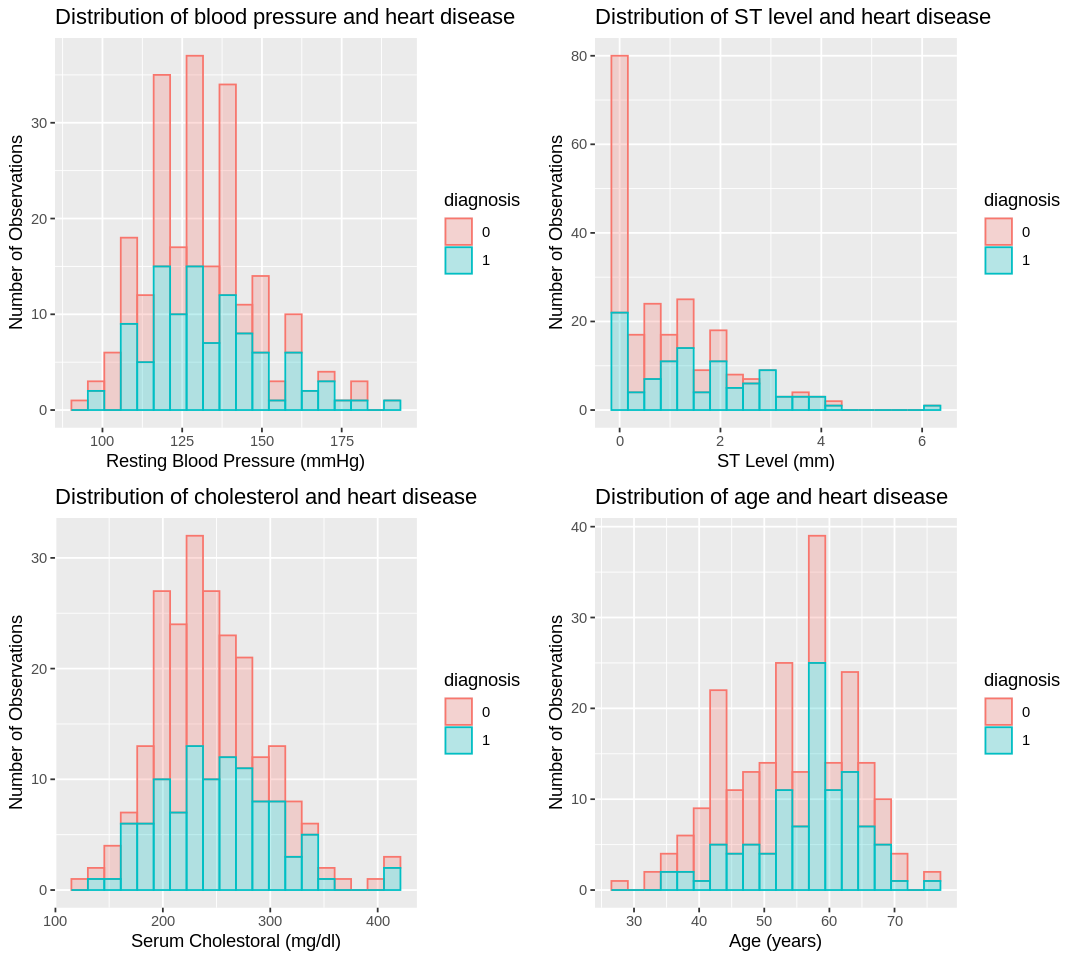

In [18]:
bp_distribution <- ggplot(heart_train, aes(x = resting_blood_pressure, fill = diagnosis, colour = diagnosis)) + geom_histogram(bins = 20,alpha = 0.25) + labs(x = "Resting Blood Pressure (mmHg)", y = "Number of Observations")+ggtitle('Distribution of blood pressure and heart disease',)
                     
chol_distribution <- ggplot(heart_train, aes(x = chol, fill = diagnosis, colour = diagnosis)) + geom_histogram(bins = 20, alpha = 0.25) + labs(x ="Serum Cholestoral (mg/dl)", y = "Number of Observations")+ggtitle('Distribution of cholesterol and heart disease')

age_distribution <- ggplot(heart_train, aes(x = age, fill = diagnosis, colour = diagnosis)) + geom_histogram(bins = 20,alpha = 0.25) + labs(x= "Age (years)", y = "Number of Observations")+ggtitle('Distribution of age and heart disease')

st_distribution <- ggplot(heart_train, aes(x = ST_level, fill = diagnosis, colour = diagnosis)) + geom_histogram(bins = 20, alpha = 0.25) + labs(x = "ST Level (mm)", y = "Number of Observations")+ggtitle('Distribution of ST level and heart disease')

plot_grid(bp_distribution, st_distribution, chol_distribution, age_distribution)

#### Takeaways from visualization

In the plots above we can see that the prevalence of patients with heart disease increases as the resting blood pressure increases as well as for the ST level and the age. The ST level appears to have the strongest relationship with the presence of a heart disease. Based on research, we thought that cholesterol would be a good predictor to diagnose the presence of heart disease, but from this visualization we can see that the relationship, if there is indeed a relationship, is weak therefore cholesterol will not serve as a good predictor.

## Model Building & Choosing Best K

In [8]:
set.seed(2023)
knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> set_engine("kknn") |> set_mode("classification")
knn_recipe <- recipe(diagnosis~ST_level+resting_blood_pressure+age, data = heart_train) |> step_scale(all_predictors()) |> step_center(all_predictors())
data_fold <- vfold_cv(heart_train, v = 10, strata = diagnosis)
k_values<-tibble(neighbors=seq(from=1, to=20, by=2))
best_k <- workflow() |> add_model(knn_spec_tune) |> add_recipe(knn_recipe) |> tune_grid(data_fold, grid = k_values) |> collect_metrics()

! Fold01: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold02: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold03: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold04: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold05: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold06: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold07: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring 

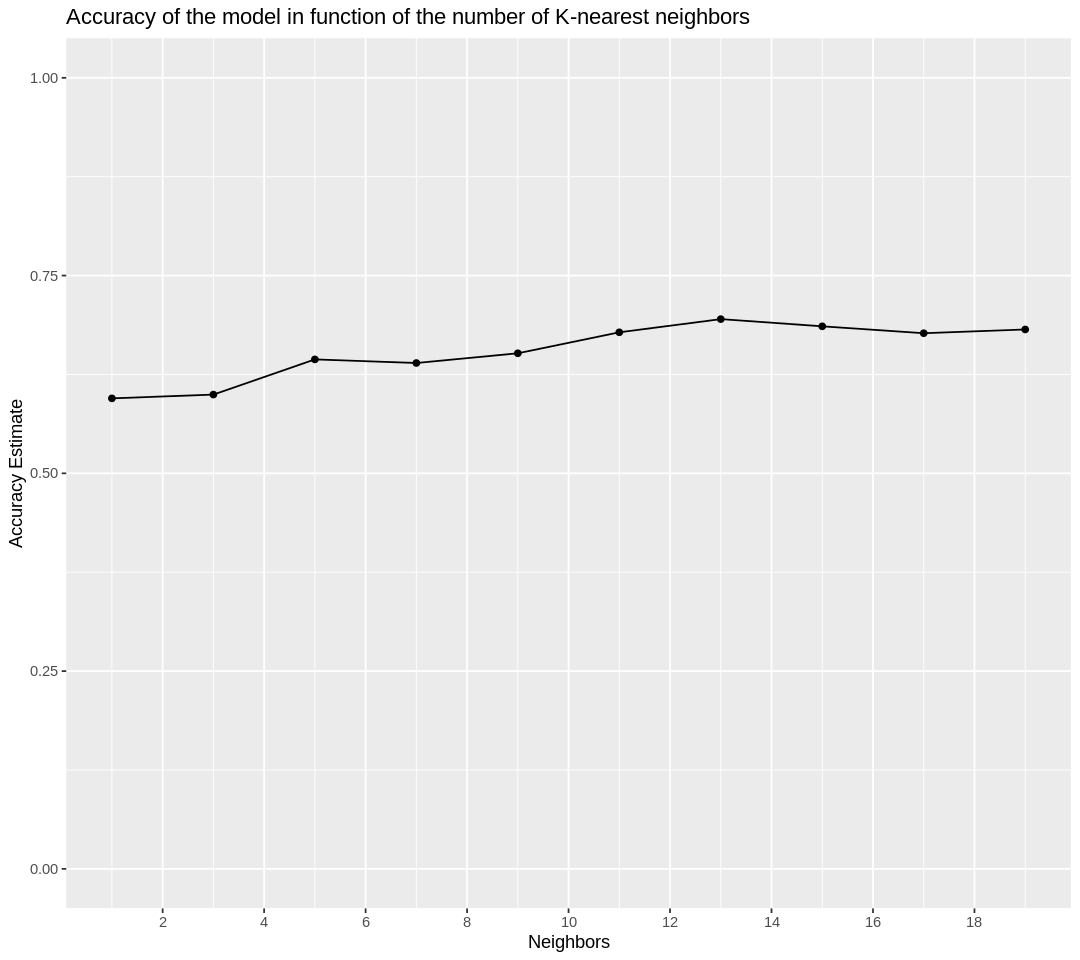

In [19]:
#we choose the best k parameter
accuracy_plot <- best_k |> filter(.metric == "accuracy") |> ggplot(aes(x = neighbors, y = mean)) + geom_point() + geom_line() + labs(x = "Neighbors", y = "Accuracy Estimate") +
     scale_x_continuous(breaks = seq(0, 20, by = 2)) + 
     scale_y_continuous(limits = c(0, 1.0))+
ggtitle('Accuracy of the model in function of the number of K-nearest neighbors')
accuracy_plot

In [10]:
#it appears that the best value is k = 13, but let's verify to make sure
k_model<-best_k|>filter(.metric=='accuracy')|>filter(mean==max(mean))|>select(neighbors)|>pull()
k_model

[1] 13

As we can see below, the best value for k is indeed 13 neighbors as it has the greatest accuracy out of the
possible values for k, but this value could differ if the dataset was different.

In [11]:
#Now we make the final model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_model) |> set_engine("kknn") |> set_mode("classification")
knn_recipe <- recipe(diagnosis~ST_level+resting_blood_pressure+age, data = heart_train) |> step_scale(all_predictors()) |> step_center(all_predictors())
knn_fit <- workflow() |> add_model(knn_spec) |> add_recipe(knn_recipe) |> fit(heart_train)

## Model Evaluation

In [12]:
prediction <- predict(knn_fit, heart_test) |> bind_cols(heart_test)
accuracy <- metrics(prediction, truth = diagnosis, estimate = .pred_class)|>filter(.metric=='accuracy')
accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7236842


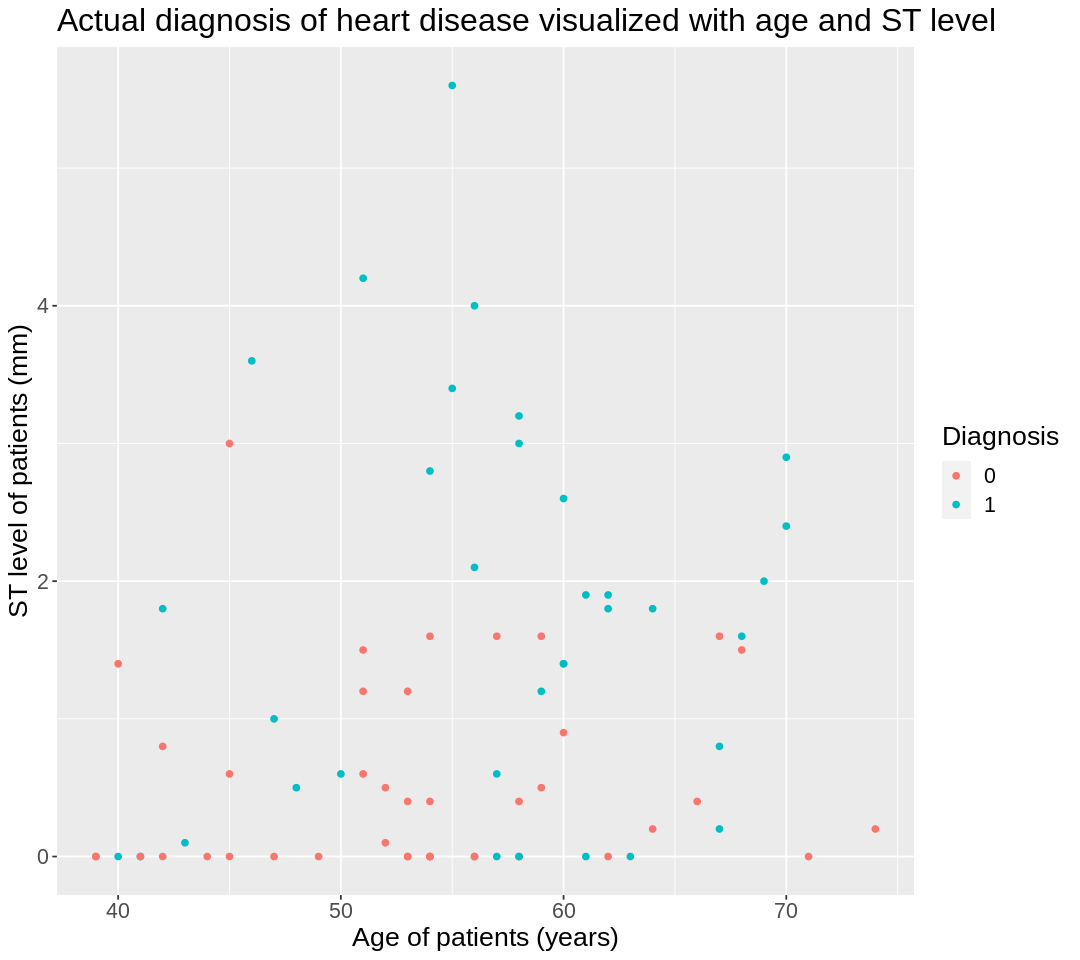

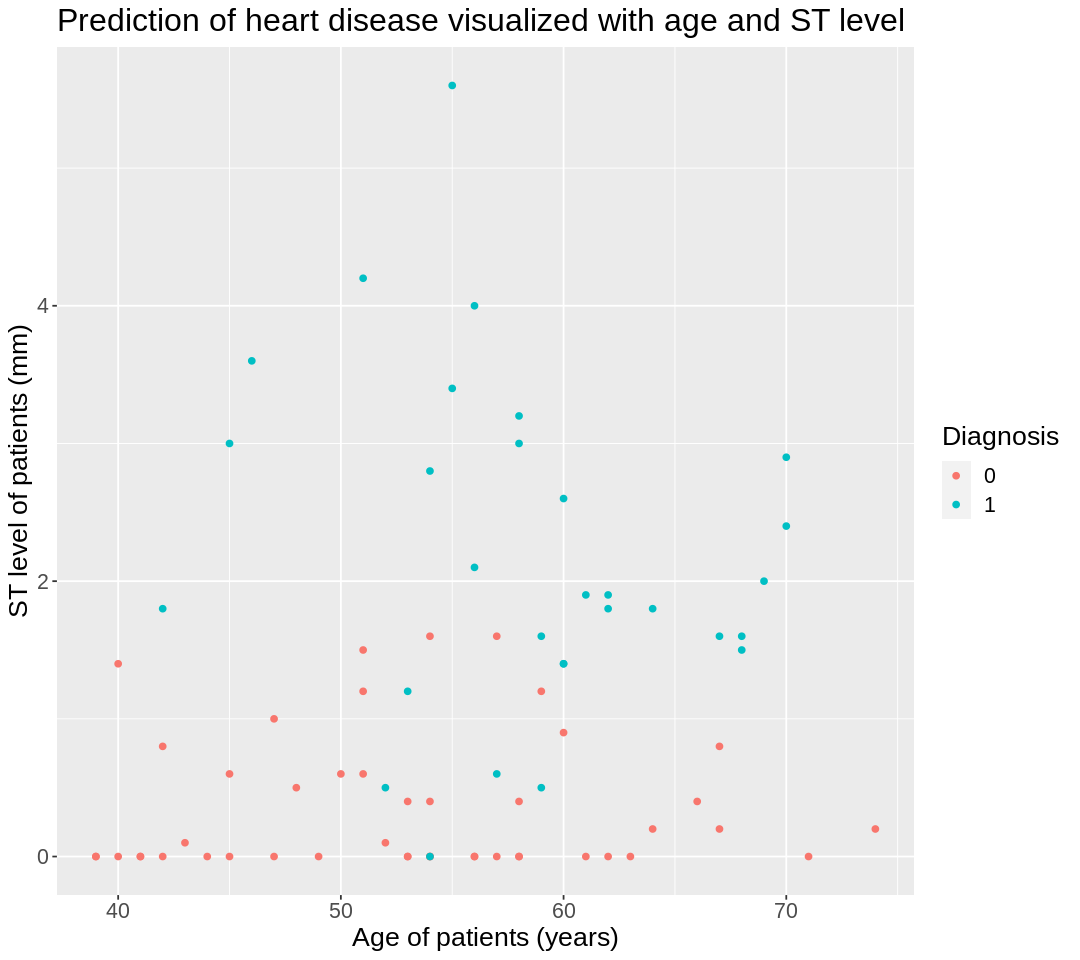

In [13]:
#Comparing the prediction for the diagnosis and the actual diagnosis
options(repr.plot.width = 9, repr.plot.height = 8)
prediction_plot_age_ST<-prediction|>
ggplot(aes(x=age, y=ST_level, colour=.pred_class))+
    geom_point()+
       labs(x='Age of patients (years)', y='ST level of patients (mm)', colour='Diagnosis')+
ggtitle('Prediction of heart disease visualized with age and ST level')+
theme(text=element_text(size=16))


testing_plot_age_ST<-prediction|>
ggplot(aes(x=age, y=ST_level, colour=diagnosis))+
geom_point()+
labs(x='Age of patients (years)', y='ST level of patients (mm)', colour='Diagnosis')+
ggtitle('Actual diagnosis of heart disease visualized with age and ST level')+
theme(text=element_text(size=16))
testing_plot_age_ST
prediction_plot_age_ST

As we can see from the scatterplots above, the prediction of the models are similar to the actual diagnosis
of the patients.

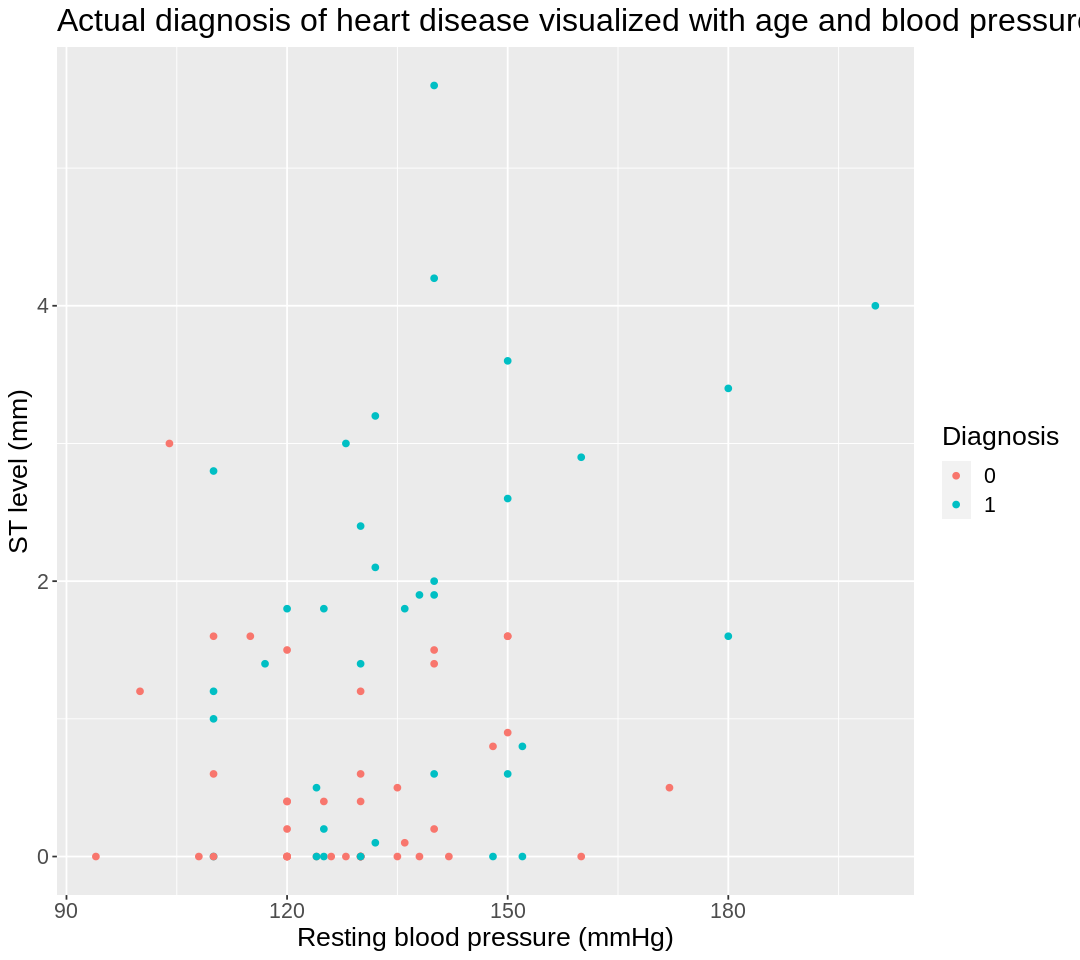

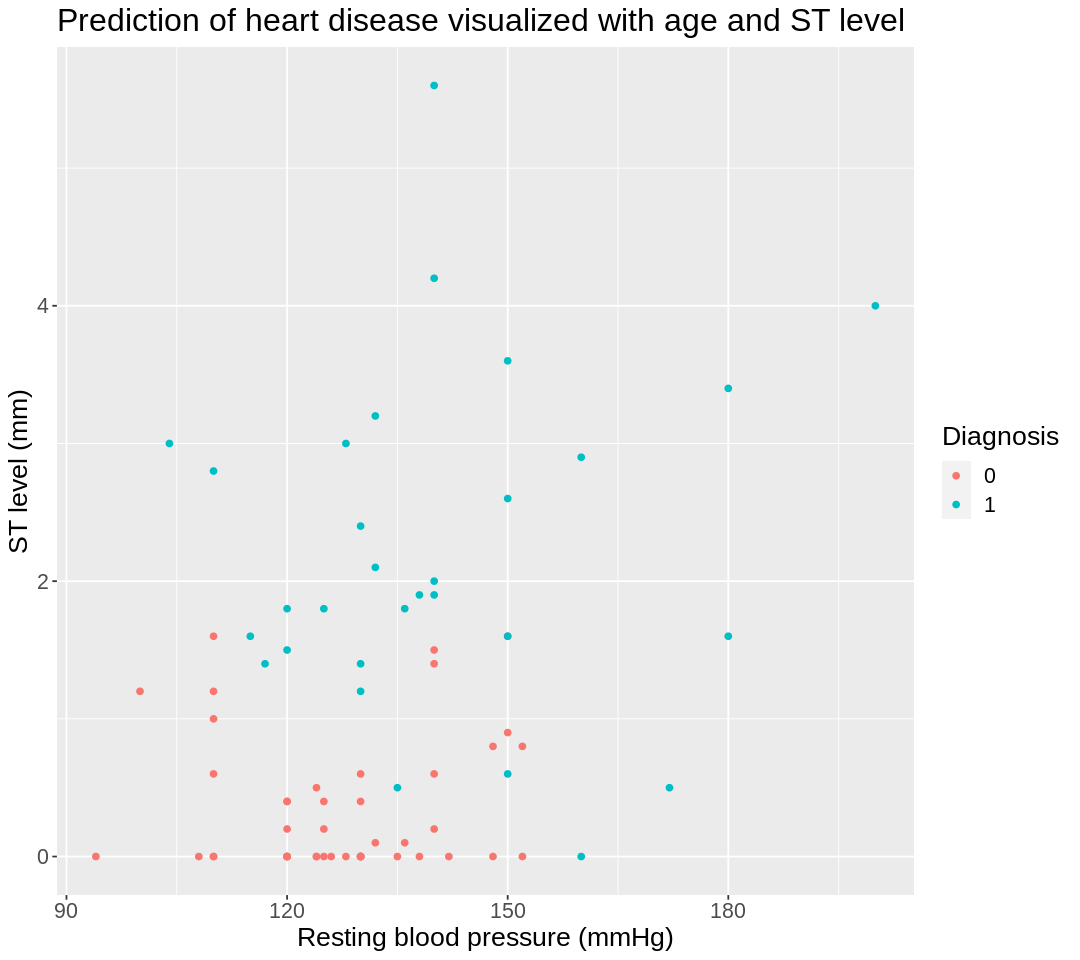

In [14]:
options(repr.plot.width = 9, repr.plot.height = 8)
prediction_plot_st_bp<-prediction|>
ggplot(aes(x=resting_blood_pressure, y=ST_level, colour=.pred_class))+
    geom_point()+
       labs(y='ST level (mm)', x='Resting blood pressure (mmHg)', colour='Diagnosis')+
ggtitle('Prediction of heart disease visualized with age and ST level')+
theme(text=element_text(size=16))


testing_plot_st_bp<-prediction|>
ggplot(aes(y=ST_level, x=resting_blood_pressure, colour=diagnosis))+
geom_point()+
labs(y='ST level (mm)', x='Resting blood pressure (mmHg)', colour='Diagnosis')+
ggtitle('Actual diagnosis of heart disease visualized with age and blood pressure')+
theme(text=element_text(size=16))
testing_plot_st_bp
prediction_plot_st_bp

Again from these two graphs, we can see that the model's predictions yield a similar distribution of 
patients with heart disease to that of the actual diagnosis.

Another takeaway that can be made from the two comparisons that were made is that the model appears to be much better at predicting the diagnosis of a patient when the ST level is really high (>2mm). As was stated earlier, the ST level is the predictor that has the strongest relationship with the prevalence of heart disease.